# Retrain kwargs manager with other inputs!

## 0) Setup

In [1]:
import sys
sys.path.insert(0, 'C:\\Users\\manuf\\Documents\\Repositories\\metaheuristic-vrpldtt\\alns\\CompAnalysis')


import copy
import pickle
from os import listdir, path
from os.path import isfile, join

# custom python import
import numpy as np
from sklearn import tree
from sklearn.tree import _tree
from reg_tree_tuning.parameter_tuning import RegressionTreeParameterTuner

# c++ imports
from ALNSv2 import ALNS
from ALNSv2 import ALNSData

import reg_tree_tuning

### setup helper functions

In [2]:
# 1) Rebuild the tree and object!
def get_solutions(path):
    files = []
    for f in listdir(path):
        try:
            if f[-4:] == ".pkl":
                raw_file = open(join(path, f), 'rb')
                data = pickle.load(raw_file)
                files.append(data)
        except TypeError:
            logging.WARN(f"File {f} is not a pickleable object. SKIP")
    return files

def dummy_coding(value, val_domain):
    ret_values = np.zeros(len(val_domain))
                      
    for j, y in enumerate(val_domain):
        if y == value:
            ret_values[j] = 1
            break
                
    return ret_values

def dummy_coding_arr(values, val_domain):
    ret_values = np.zeros(len(val_domain))
    
    for x in values:
        for j, y in enumerate(val_domain):
            if x == y:
                ret_values[j] = 1
            
    return ret_values


def get_modified_z_scores(y):
    """
    3 options:
     - MAD is 0 -> use MEAN
     - If MEAN is also 0 -> return 0s

    """
    median_y = np.median(y)
    median_absolute_deviation_y = round(
        np.median([np.abs(y - median_y) for y in y]), 5)

    if median_absolute_deviation_y != 0:
        return [0.6745 * (val - median_y) / median_absolute_deviation_y for val in y]
    else:
        standard_deviation = round(np.std(y), 5)
        if standard_deviation != 0:
            return [0.6745 * (val - median_y) / standard_deviation for val in y]
        else:
            return np.zeros(len(y))


def get_modified_z_scores_ids(y, ids):
    data_tracking = {aid: [] for aid in set(ids)}

    for pos, aid in enumerate(ids):
        data_tracking[aid].append(pos)

    y_ret = y.copy()
    for inst_id in data_tracking:
        sol_ids = data_tracking[inst_id]
        y_ret[sol_ids] = get_modified_z_scores(y[sol_ids])

    return y_ret

def optimize_kwargs_manager(tree, kwargs_manager):
            """
            Get the rule-set of a tree of type sklearn.tree.tree.DecisionTreeRegressor
             leading to the leaf with the best value

            Args:
                tree:               Instances of scikit tree
                kwargs_manager:     Current keyword arguments manager whose
                                    domains should be adjusted according to the tree

            """
            # get node with biggest value
            tree_ = tree.tree_

            # first entry of the array is the lower bound, the second is the upper bound

            def recursive_child_rules_quality(node):
                """
                This function recursively iterates through the tree and adjusts the keyword arguments manager
                according to the best leaf found.

                IMPORTANT:
                The last rule is most likely the most strict rule.
                Therefore, if we set one rule once we are not allowed to set it again! (rule_change_indicator)

                Args:
                    node: Child leaf to be selected

                Returns: improved rule_set

                """
                nonlocal kwargs_manager, tree_
                feature_id = tree_.feature[node]
                threshold = tree_.threshold[node]

                if tree_.feature[node] != _tree.TREE_UNDEFINED:
                    values_1, kwargs_man1, rule_change_indicator1 = recursive_child_rules_quality(
                        tree_.children_left[node])
                    values_2, kwargs_man2, rule_change_indicator2 = recursive_child_rules_quality(
                        tree_.children_right[node])

                    # select the best leaf according
                    # set the rule set according to the best leaf
                    if values_1 < values_2:
                        # we must use deep copy to ensure that both the dictionary as the lists are copied instances
                        values, best_kwargs_man, rule_change_indicator = values_1, copy.deepcopy(
                            kwargs_man1), copy.deepcopy(
                            rule_change_indicator1)
                        # check if the rule was already changed if not change and save the change
                        # append new rule (children left means smaller equal -> new upper bound)
                        if not rule_change_indicator[feature_id][1]:
                            best_kwargs_man.attributes[feature_id].val_range[1] = threshold
                            rule_change_indicator[feature_id][1] = True
                    else:
                        values, best_kwargs_man, rule_change_indicator = values_2, copy.deepcopy(
                            kwargs_man2), copy.deepcopy(
                            rule_change_indicator2)
                        # check if the rule was already changed if not change and save the change
                        # append new rule (children left means bigger -> new lower bound)
                        if not rule_change_indicator[feature_id][0]:
                            best_kwargs_man.attributes[feature_id].val_range[0] = threshold
                            rule_change_indicator[feature_id][0] = True
                    return values, best_kwargs_man, rule_change_indicator
                else:  # end of leaf, base version
                    rule_change_indicator = {aid: [False, False] for aid in range(len(kwargs_manager.attributes))}
                    return tree_.value[node][0][0], kwargs_manager, rule_change_indicator

            # build each branch and select the rules of the branch with the better objective value
            # return the new rule set!
            return recursive_child_rules_quality(0)[0:2]

## 1) Import data and set it up for training

In [3]:
path = "C:\\Users\\manuf\\OneDrive\\Dokumente\\Universitaet\\Masterthesis\\data\\1_tuning_results\\vrpldtt"
solutions = get_solutions(join(path, "2_search_space"))
values = np.array([sol["metrics"]["value"]for sol in solutions])
ids = np.array([sol["data_id"] for sol in solutions])

# Import data with dummy coding
# all_x = np.array([[*dummy_coding_arr(sol["parameter"]["destroy_operators"],["random_destroy", "route_destroy", "demand_destroy", "time_destroy",
#                                              "node_pair_destroy",
#                                              "shaw_destroy", "worst_destroy", "distance_similarity",
#                                              "window_similarity",
#                                              "demand_similarity"]),
#                    *dummy_coding_arr(sol["parameter"]["repair_operators"],  ["2_regret", "3_regret", "5_regret", "basic_greedy", "random_greedy",
#                                             "deep_greedy", "beta_hybrid"])
#                   ] for sol in solutions])

all_x = np.array([[sol["parameter"]["shakeup_log"],
                  sol["parameter"]["mean_removal_log"]] for sol in solutions])

all_y = get_modified_z_scores_ids(values, ids)

## 2) Train tree

In [18]:
tree_kwargs = {'criterion': "mse", 'splitter': "best", 'max_depth': None,
               'min_samples_split': 20, 'min_samples_leaf': 10}

reg_tree = tree.DecisionTreeRegressor(**tree_kwargs)
reg_tree.fit(all_x, all_y)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=10,
           min_samples_split=20, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

# 2.1 Plot tree

In [19]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
import importlib
importlib.reload(pydotplus)

dot_data = StringIO()
export_graphviz(reg_tree, out_file=dot_data,  
                feature_names=[f"shakeup log", "mean removal log beta"],
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
graph.create_png()

Qt: Untested Windows version 6.2 detected!
C:/Program Files (x86)/Graphviz2.38/bin/gvedit.exe: illegal option -- 'T'
C:/Program Files (x86)/Graphviz2.38/bin/gvedit.exe : option -T unrecognized - ignored
C:/Program Files (x86)/Graphviz2.38/bin/gvedit.exe: illegal option -- 'p'
C:/Program Files (x86)/Graphviz2.38/bin/gvedit.exe : option -p unrecognized - ignored
C:/Program Files (x86)/Graphviz2.38/bin/gvedit.exe: illegal option -- 'n'
C:/Program Files (x86)/Graphviz2.38/bin/gvedit.exe : option -n unrecognized - ignored
C:/Program Files (x86)/Graphviz2.38/bin/gvedit.exe: illegal option -- 'g'
C:/Program Files (x86)/Graphviz2.38/bin/gvedit.exe : option -g unrecognized - ignored
Could not open attribute name file "../share/graphviz/gvedit/attributes.txt" for reading



b''

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_86\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_86\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log
  del sys.path[0]
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_86\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in log


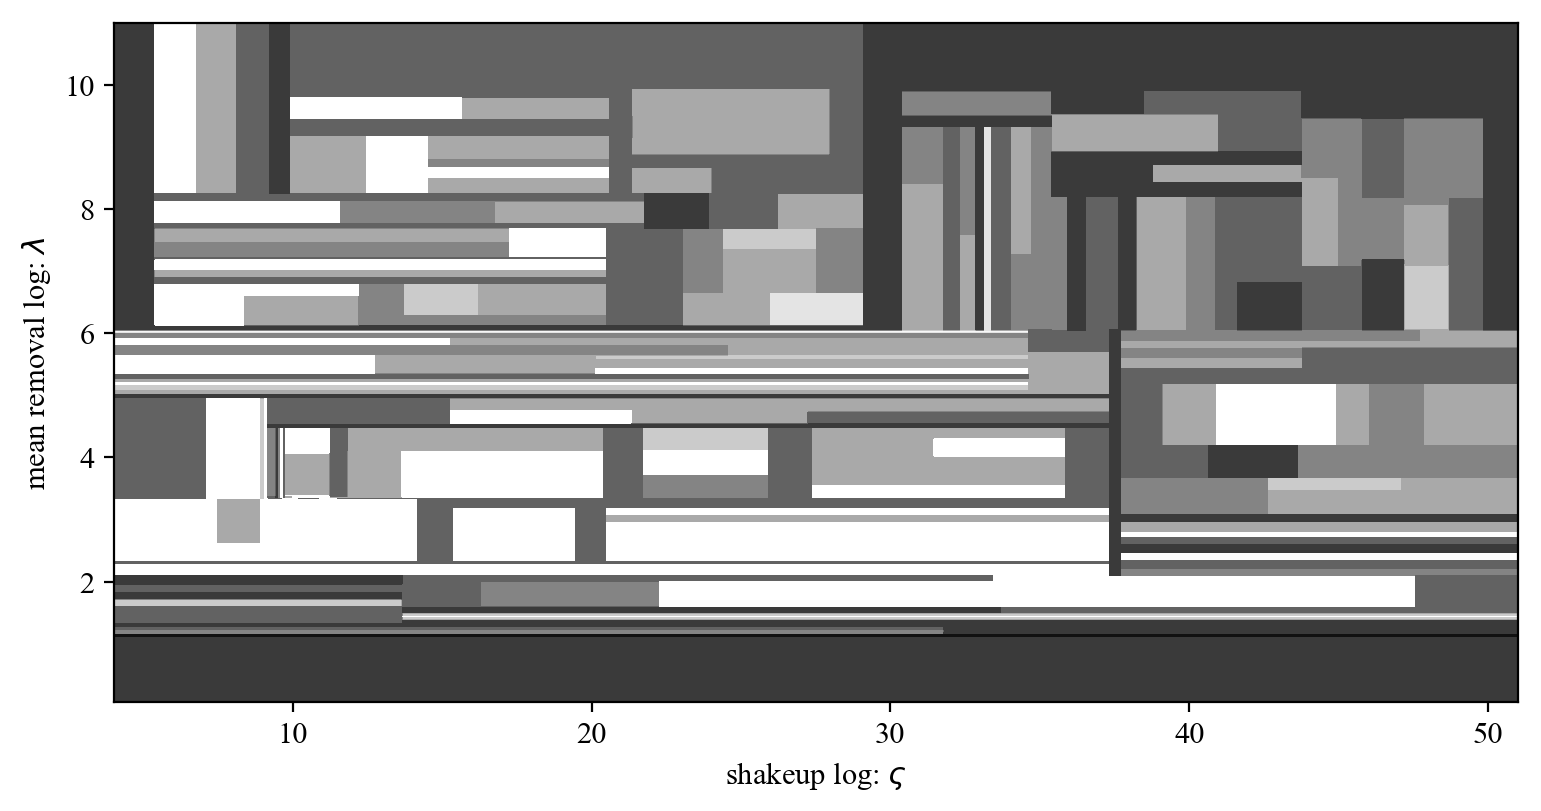

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
plt.style.use(("grayscale","paper_quer"))

# Parameters
plot_colors = "ryb"
plot_step = 0.01

reg_tree
# We only take the two corresponding features
X = all_x

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))

plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

Z = np.log(reg_tree.predict(np.c_[xx.ravel(), yy.ravel()]))
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Greys)

plt.xlabel(f"shakeup log: $ ς $")
plt.ylabel(f"mean removal log: $ \lambda $")
# plt.legend(loc='lower right', borderpad=0, handletextpad=0)
plt.axis("tight")
plt.show()

In [14]:
y

array([ 5.19433643,  5.19433643, -0.39378161, ...,         nan,
               nan,         nan])

## 3) Train kwargs manager and check values

In [26]:
new_man = reg_tree_tuning.kwargs_manager.KwargsManager()
new_man.fit({"initial_temperature": ["random_destroy", "route_destroy", "demand_destroy", "time_destroy",
                                             "node_pair_destroy",
                                             "shaw_destroy", "worst_destroy", "distance_similarity",
                                             "window_similarity",
                                             "demand_similarity"],
            "repair_operators": ["2_regret", "3_regret", "5_regret", "basic_greedy", "random_greedy",
                                            "deep_greedy", "beta_hybrid"]})

new_man.fit({"initial_temperature": (100, 1, 0.1, 0.01, 0.001, 0.0001),
             "cooling_rate": (0.99, 0.995, 0.999, 0.99975, 0.9999)})

In [27]:
optimize_kwargs_manager(reg_tree, new_man)[1].attributes

[{'name': 'initial_temperature', 'val_range': [0, 1], '__dummyname__': 100, 'category': 100, 'multi': False},
 {'name': 'initial_temperature', 'val_range': [0, 1], '__dummyname__': 1, 'category': 1, 'multi': False},
 {'name': 'initial_temperature', 'val_range': [0, 1], '__dummyname__': 0.1, 'category': 0.1, 'multi': False},
 {'name': 'initial_temperature', 'val_range': [0, 1], '__dummyname__': 0.01, 'category': 0.01, 'multi': False},
 {'name': 'initial_temperature', 'val_range': [0, 1], '__dummyname__': 0.001, 'category': 0.001, 'multi': False},
 {'name': 'initial_temperature', 'val_range': [0, 1], '__dummyname__': 0.0001, 'category': 0.0001, 'multi': False},
 {'name': 'cooling_rate', 'val_range': [0, 1], '__dummyname__': 0.99, 'category': 0.99, 'multi': False},
 {'name': 'cooling_rate', 'val_range': [0, 1], '__dummyname__': 0.995, 'category': 0.995, 'multi': False},
 {'name': 'cooling_rate', 'val_range': [0, 1], '__dummyname__': 0.999, 'category': 0.999, 'multi': False},
 {'name': 'co

In [85]:
optimize_kwargs_manager(reg_tree, new_man)[1].attributes

[{'name': 'destroy_operators', 'val_range': [0, 1], '__dummyname__': 'random_destroy', 'category': 'random_destroy', 'multi': True},
 {'name': 'destroy_operators', 'val_range': [0, 0.5], '__dummyname__': 'route_destroy', 'category': 'route_destroy', 'multi': True},
 {'name': 'destroy_operators', 'val_range': [0.5, 1], '__dummyname__': 'demand_destroy', 'category': 'demand_destroy', 'multi': True},
 {'name': 'destroy_operators', 'val_range': [0, 0.5], '__dummyname__': 'time_destroy', 'category': 'time_destroy', 'multi': True},
 {'name': 'destroy_operators', 'val_range': [0.5, 1], '__dummyname__': 'node_pair_destroy', 'category': 'node_pair_destroy', 'multi': True},
 {'name': 'destroy_operators', 'val_range': [0.5, 1], '__dummyname__': 'shaw_destroy', 'category': 'shaw_destroy', 'multi': True},
 {'name': 'destroy_operators', 'val_range': [0, 1], '__dummyname__': 'worst_destroy', 'category': 'worst_destroy', 'multi': True},
 {'name': 'destroy_operators', 'val_range': [0.5, 1], '__dummynam

# 99) Special relativity analysis
Get relative values of all reward and functor values!

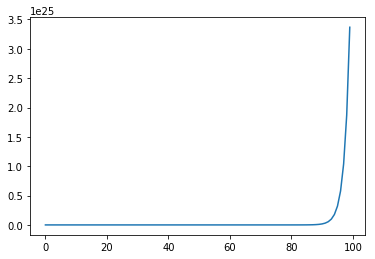

In [40]:
rel_vals = []
for row in all_x:
    new_row = []
    for i, rew1 in enumerate(row[0:-1]):
        for rew2 in row[i+1:-1]:
            new_row.append(rew1/rew2)
            
    new_row.append(row[-1])
    rel_vals.append(new_row)
    
# fig, axs = plt.subplots(1, 5, figsize=(50, 10), dpi=200)
titles = [f"\sigma_{1} vs \sigma_{2}",
"best_vs_divers",
"best_vs_unqiue",
"best_vs_penalty",
"better_vs_divers",
"better_vs_unique",
"better_vs_penalty",
"divers_vs_unique",
"divers_vs_penalty",
"unique_vs_penalty"]